In [16]:
import requests
import json
import datetime

today = datetime.date.today()
year = today.year
year_prev = year - 1

# Variables for in the url
latitude = 52.01
longitude = 4.36
start_date = f"{year_prev}-01-01"
end_date = f"{year_prev}-12-31"

# API Get max historical temperatures
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max&timezone=Europe%2FBerlin"

# Send the API request and get the response
response = requests.get(url)
response = response.text
# print(url) # for checking in browser

# Make a dictionary out of the response and extract necessary portion
dict_response = json.loads(response)
lst = dict_response['daily']['temperature_2m_max']

# remove empty data entries & get highest temperature measured
lst = [x for x in lst if x is not None]
highest_temp = max(lst)

# API Get Humidity data (this is only available in hourly data instead of daily hence different api request)
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly=relativehumidity_2m&timezone=Europe%2FBerlin"

# Send the API request and get the response
response = requests.get(url)
response = response.text

# Make a dictionary out of the response and extract necessary portion
dict_response = json.loads(response)
lst = dict_response['hourly']['relativehumidity_2m']

# remove empty data entries & get average humidity measured
lst = [x for x in lst if x is not None]
average_humidity = sum(lst) / len(lst)


# https://www.knmi.nl/nederland-nu/KNMI14_klimaatscenarios/kerncijfers
HumidityPredictionKNMI = average_humidity - 2.5
TempPredicitonKNMI = highest_temp + 2.3

# improvement point: get highest humidity level of the max temperature date instead of average of all year

2.1393023426520853e-10
3.5524781511990788e-34 7.823761179033628e-35


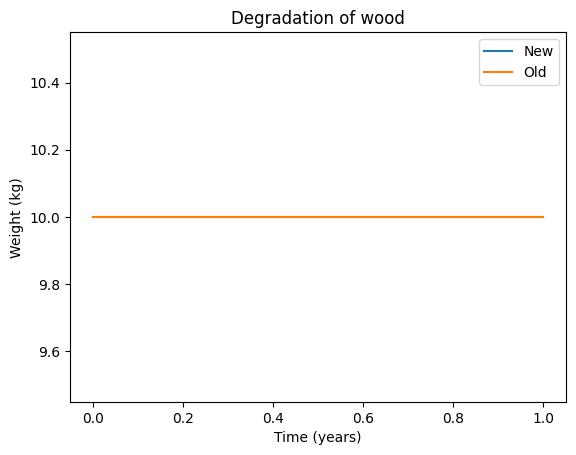

In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np

material = "wood"
TKelvinOld = highest_temp + 273.15
TKelvinNew = TempPredicitonKNMI + 273.15
RHumOld = average_humidity
RHumNew = HumidityPredictionKNMI
kg = 10 # weight of structure
Height = 0.2 #m
Width = 0.2 #m
Length = 3 #m
connection = "fixed"
DesignStillwaterDepthMM = 2 # example 

match material:
    case "steel":
        # https://www.researchgate.net/publication/348485447_Inhibition_Effect_of_Hydrazine-Derived_Coumarin_on_a_Mild_Steel_Surface_in_Hydrochloric_acid
        R = 8.31446261815324 # Universal gas Constant J K-1 mol-1
        A = 3.713 * 10**25 #preexponential factor
        EActEnergy = 32.47 * 1000 # activation energy (kJ mol-1)

# log Cr = log ( A - Ea / Rt)
        # https://www.researchgate.net/publication/248262403_Thermodynamic_study_of_metal_corrosion_and_inhibitor_adsorption_processes_in_mild_steel1-methyl-44'-X-styryl_pyridinium_iodideshydrochloric_acid_systems

        MassLossOld = A * math.exp(-EActEnergy / (R * TKelvinOld))
        MassLossNew = A * math.exp(-EActEnergy / (R * TKelvinNew))

        molarmass = 55.845 # gram/mole https://sciencing.com/molar-mass-steel-10067961.html

        # rate (molecules) to mol (avogadro's number)
        MassLossOld = MassLossOld / 6.022e23
        MassLossNew = MassLossNew / 6.022e23

        gram = kg * 1000
        mol = gram / molarmass

        # convertion from mol to kg
        weight = (mol * molarmass) / 1000 # in kg
        lossold = (MassLossOld * molarmass) / 1000
        lossnew = (MassLossNew * molarmass) / 1000
        print(MassLossNew, lossnew)

        
        # seconds and years
        time = np.array([0, 1])
        time_seconds = time.astype(np.int64) * 3600 * 24 * 365
        time_years = time_seconds / (3600 * 24 * 365) # convert time to years

        # forumlas for plotting
        formulanew = (weight - ((lossnew) * (time_seconds.astype(np.int64))))
        formulaold = (weight - ((lossold) * (time_seconds.astype(np.int64))))

        # x_max = np.max(time_seconds)
        # y_max = (np.max(formulanew) + (np.max(formulanew)*0.1))
        # y_min = np.max(formulanew)*0.9

        fig, ax = plt.subplots()
        ax.plot(time_years, formulanew, label='New')
        ax.plot(time_years, formulaold, label='Old')
        ax.set_title("Degradation of steel due to corrosion")
        ax.set_ylabel('Weight (kg)')
        ax.set_xlabel('Time (years)')
        # ax.set_ylim(y_min, y_max)  # Set x-axis limit from 0
        # ax.set_xticks(time_years)  # Set x-axis ticks to the exact values of time_years
        ax.legend()
        plt.show()

    case "concrete":
        # # concrete pdf https://inis.iaea.org/collection/NCLCollectionStore/_Public/28/057/28057515.pdf
        # https://www.mdpi.com/2075-5309/13/4/965
        # Lu Z-H, Lun P-Y, Li W, Luo Z, Li Y, Liu P. Empirical model of corrosion rate for steel reinforced concrete structures in chloride-laden environments. Advances in Structural Engineering. 2019;22(1):223-239. doi:10.1177/1369433218783313 https://journals.sagepub.com/doi/full/10.1177/1369433218783313

        time = 1 # years
        wc = 0.45 # water cement ratio
        C = 50 # concrete cover thickness mm
        Ct = 0.20  # chloride content by weight of concrete (kg/m3)
        Rho = 1 # concrete resistivity (kΩ cm)

        # Define constants
        density = 7.874  # g/cm3 https://amesweb.info/Materials/Density_of_Iron.aspx
        atomic_weight_iron = 55.845  # g/mol atomic weight https://ciaaw.org/iron.htm
        faraday_constant = 96.485  # C/mol proportionality constant https://www.sciencedirect.com/topics/engineering/faradays-constant#:~:text=The%20known%20Faraday%20constant%2096%2C485,by%201%20mol%20of%20electrons.

        mm_per_year_results_new = []
        mm_per_year_results_old = []

        # Define time values
        time_values = [i for i in range(1, 101)]

        for time in time_values:
            lognew = (math.log(Ct - (3034 / (TKelvinNew * (2.5 + RHumNew) - (5*(10**-3) * Rho)))))
            corrosionratetimewisenew = (1.38 * (((1 - wc)**-1.64) / (((1 + time) * C)**(1/3)))) * math.exp(1.23 + 0.618 * lognew) # (μA/cm2)

            # Define input parameters
            corrosion_rate = corrosionratetimewisenew   # μA/cm2 in a year

            # Coulombs/cm2 (1 microampere is 10**-6 coulombs)
            coulombscm2 = corrosion_rate * 10**-6

            # https://en.wikipedia.org/wiki/Faraday%27s_laws_of_electrolysis
            # https://www.sciencedirect.com/science/article/pii/S0958946520300275
            # m = (Q * M) / (n * Z = Z) formula for Faraday's first law
            # mass loss rate in g/cm2/year using Faraday's Law
            mass_loss_rate = (coulombscm2 * atomic_weight_iron) / (2 * faraday_constant) # 2 for n is used because 2 electrons are transferred in the electrochemical reaction during oxidation of Fe

            # Convert mass loss rate from g/cm2/year to mm/year using density of iron
            mm_per_year = (mass_loss_rate * 10**7) / density

            # append mm_pet_year in list
            mm_per_year_results_new.append(mm_per_year)

        # same loop but for old
        for time in time_values:
            logold = (math.log(Ct - (3034 / (TKelvinOld * (2.5 + RHumOld) - (5*(10**-3) * Rho)))))
            corrosionratetimewiseold = (1.38 * (((1 - wc)**-1.64) / (((1 + time) * C)**(1/3)))) * math.exp(1.23 + 0.618 * logold) # (μA/cm2)

            # Define input parameters
            corrosion_rate = corrosionratetimewiseold   # μA/cm2 in a year

            # Coulombs/cm2 (1 microampere is 10**-6 coulombs)
            coulombscm2 = corrosion_rate * 10**-6

            # https://en.wikipedia.org/wiki/Faraday%27s_laws_of_electrolysis
            # https://www.sciencedirect.com/science/article/pii/S0958946520300275
            # m = (Q * M) / (n * Z = Z) formula for Faraday's first law
            # mass loss rate in g/cm2/year using Faraday's Law
            mass_loss_rate = (coulombscm2 * atomic_weight_iron) / (2 * faraday_constant) # 2 for n is used because 2 electrons are transferred in the electrochemical reaction during oxidation of Fe

            # Convert mass loss rate from g/cm2/year to mm/year using density of iron
            mm_per_year = (mass_loss_rate * 10**7) / density

            # append mm_pet_year in list
            mm_per_year_results_old.append(mm_per_year)


        # time spans to calculate accumulated corrosion of
        time = [1, 5, 10, 15, 20, 30, 40, 50, 100]

        accumulated_data_new = []
        accumulated_data_old = []

        # Accumulate the years of data based on given time
        for t in time:
            accumulated_data_new.append(sum(mm_per_year_results_new[:t]))

        # Accumulate the years of data based on given time
        for t in time:
            accumulated_data_old.append(sum(mm_per_year_results_old[:t]))

        # plot the data
        ig, ax = plt.subplots()
        ax.plot(time, accumulated_data_new, label='New')
        ax.plot(time, accumulated_data_old, label='Old')
        ax.set_title("Degradation of concrete")
        ax.legend()

        # set the x and y labels
        plt.xlabel('Time (years)')
        plt.ylabel('Accumulated corrosion (mm)')

        # show the plot
        plt.show()

    case "wood":
        # validation of method https://www.fpl.fs.usda.gov/documnts/pdf2001/white01a.pdf
        # https://www.e3s-conferences.org/articles/e3sconf/pdf/2021/56/e3sconf_icsf2021_07009.pdf
        R = 8.31446261815324 # Universal gas Constant J K-1 mol-1
        #EActEnergy = 132.49 * 1000 # https://www.sciencedirect.com/science/article/abs/pii/S096085241931329X
        EActEnergy = 130 * 1000 # file:///D:/Downloads/Kinetic_analysis_of_thermal_degradation_of_Cedrela.pdf
        A = 1.57* (10**12) # 1.57* (10**12) # preexponential factor https://www.researchgate.net/publication/299646285_Modeling_of_the_pyrolysis_of_biomass_under_parabolic_and_exponential_temperature_increases_using_the_Distributed_Activation_Energy_Model
        MassLossOld =  A * math.exp(-EActEnergy / (R * TKelvinOld)) # first-order Arrhenius equation, massloss/rateconstant mol^-1 s^-1
        MassLossNew =  A * math.exp(-EActEnergy / (R * TKelvinNew)) # first-order Arrhenius equation, massloss/rateconstant mol^-1 s^-1
        print(MassLossNew)
        
        molarmass = 220.2339 # gram/mole C6H12O6 + Ca https://www.plantchicago.org/post/thinking-circular-with-chemistry#:~:text=In%20actuality%20wood%20is%20mostly,formula%20is%3A%20C6H12O6%20%2B%20Ca.

        # rate (molecules) to mol (avogadro's number)
        MassLossOld = MassLossOld / 6.022e23
        MassLossNew = MassLossNew / 6.022e23

        gram = kg * 1000
        mol = gram / molarmass

        # convertion from mol to kg
        weight = (mol * molarmass) / 1000 # in kg
        lossold = (MassLossOld * molarmass) / 1000
        lossnew = (MassLossNew * molarmass) / 1000
        print(MassLossNew, lossnew)

        
        # seconds and years
        time = np.array([0, 1])
        time_seconds = time.astype(np.int64) * 3600 * 24 * 365
        time_years = time_seconds / (3600 * 24 * 365) # convert time to years

        # forumlas for plotting
        formulanew = (weight - ((lossnew) * (time_seconds.astype(np.int64))))
        formulaold = (weight - ((lossold) * (time_seconds.astype(np.int64))))

        # x_max = np.max(time_seconds)
        # y_max = (np.max(formulanew) + (np.max(formulanew)*0.1))
        # y_min = np.max(formulanew)*0.9

        fig, ax = plt.subplots()
        ax.plot(time_years, formulanew, label='New')
        ax.plot(time_years, formulaold, label='Old')
        ax.set_title("Degradation of wood")
        ax.set_ylabel('Weight (kg)')
        ax.set_xlabel('Time (years)')
        # ax.set_ylim(y_min, y_max)  # Set x-axis limit from 0
        # ax.set_xticks(time_years)  # Set x-axis ticks to the exact values of time_years
        ax.legend()
        plt.show()


In [21]:
HeightMM = Height * 1000
WidthMM = Width * 1000
LengthMM = Length * 1000

oldweight = 100
newweight = 80

ratioloss = newweight / oldweight

# volumeloss = 0.8 * HeightMM * WidthMM * LenghtMM
# equals to = 3root(0.8) * HeightMM * 3root(0.8) * WidthMM * 3root(0.8) * LenghtMM 
# crosssection = 3root(0.8) * HeightMM * 3root(0.8) * WidthMM (because 3root(ratio) * 3 = ratio)
# assuming here that degradation happens equally on all sides

heightnew = HeightMM * (ratioloss**(1/3))
widthnew = WidthMM * (ratioloss**(1/3))

Inertiaold = (((WidthMM * (HeightMM**3))) / 12 ) 
Inertianew = (((widthnew * (heightnew**3))) / 12 ) 

# from flood calc
LoadBreakN = 3.10 * 1000
LoadCombinationN = 5.19 * 1000
LoadDebrisN = 24.6 * 1000
DesignStillwaterDepthMM = 5000

# take highest value load
if LoadBreakN > max(LoadBreakN,LoadCombinationN,LoadDebrisN):
    Load = LoadBreakN
elif LoadCombinationN > max(LoadBreakN,LoadCombinationN,LoadDebrisN):
    Load = LoadCombinationN
else: 
    Load = LoadDebrisN

#  Modulus of elasticity in MPa
match material:
    case "concrete":
        Elasticity =  30 * 1000    # MPA concrete C20/25
    case "wood":
        Elasticity =  11 * 1000  # MPA wood 
    case "steel":
        Elasticity =  210 * 1000   # MPA steel 

# calculate max deflection for both breaking loads and the load combination
def deflection(Load, Inertia):
    # formula from https://structx.com/Beam_Formulas_014.html
    if connection == "fixed":
        MaxDeflection = ((Load * ((DesignStillwaterDepthMM * 2/3) ** 3) * ((DesignStillwaterDepthMM * 1/3) ** 2)) / (12 * Elasticity * Inertia * (LengthMM ** 3))) * ((3 * LengthMM) + (DesignStillwaterDepthMM * 1/3))
    # formula from https://structx.com/Beam_Formulas_008.html
    elif connection == "hinge":
        MaxDeflection = (Load * ((DesignStillwaterDepthMM * 1/3) ** 2) * ((DesignStillwaterDepthMM * 2/3) ** 2)) / (3 * Elasticity * Inertia * LengthMM)
    return MaxDeflection

deflectionold = deflection(Load, Inertiaold)
deflectionnew = deflection(Load, Inertianew)
diff = deflectionnew - deflectionold

print("if a flood were to happen of 2 meters, the deflection with old temperature values would be", round(deflectionold, 2), " mm", "whereas if it would happen with the new temperatures due to climate change the deflection would be", round(deflectionnew, 2), " mm")
print("This is a difference of:", round(diff, 2), "mm")

if a flood were to happen of 2 meters, the deflection with old temperature values would be 56.81  mm whereas if it would happen with the new temperatures due to climate change the deflection would be 60.83  mm
This is a difference of: 4.02 mm
